In [1]:
import numpy as np
from ase import io

import matplotlib.pyplot as plt

from MDAnalysis import Universe
from MDAnalysis import transformations as trans

from WatAnalysis.spectrum import calc_power_spectrum, calc_full_vacf

/home/jxzhu/apps/miniconda3/envs/leiden/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topo = "/home/jxzhu/workspace/test/test_vdos/coord.xyz"
pos_traj = "/home/jxzhu/workspace/test/test_vdos/pt-pos-1.xyz"
vel_traj = "/home/jxzhu/workspace/test/test_vdos/pt-vel-1.xyz"

u_pos = Universe(topo, pos_traj, topology_format="XYZ", format="XYZ")
u_vel = Universe(topo, vel_traj, topology_format="XYZ", format="XYZ")
atoms = io.read(topo)
transform = trans.boxdimensions.set_dimensions(atoms.cell.cellpar())
u_pos.trajectory.add_transformations(transform)

In [3]:
velocities = np.zeros((len(u_vel.trajectory), len(u_vel.select_atoms("name H")), 3))

for ts in u_vel.trajectory:
    # print(ts.frame)
    # print(u_vel.select_atoms("name H").positions[0])
    np.copyto(velocities[ts.frame], u_vel.select_atoms("name H").positions)

In [18]:
full_vacf = calc_full_vacf(velocities)
power_spectrum = calc_power_spectrum(full_vacf, 0.5e-3)

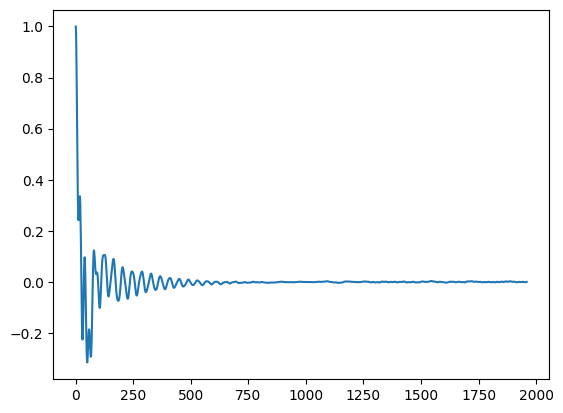

In [20]:
plt.plot(full_vacf[50000:-50000][len(full_vacf[50000:-50000]) // 2 :])

# plt.xlim(0., 100.)
plt.show()

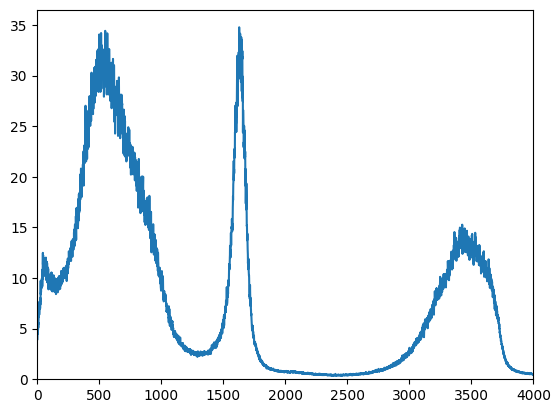

In [17]:
power_spectrum = calc_power_spectrum(full_vacf[50000:-50000], 0.5e-3)

mask = power_spectrum[0] > 0.0

plt.plot(power_spectrum[0][mask] * 100.0 / 3.0, power_spectrum[1][mask])
plt.xlim(0.0, 4000)
plt.ylim(bottom=0.0)
plt.show()

In [21]:
max_tau = 2000
d_tau = 1
tau_list = np.arange(0, max_tau + d_tau, d_tau, dtype=int)

In [22]:
hydrogen_vel_ag = u_vel.select_atoms("name H")

_vacf = np.full([len(tau_list), len(u_vel.trajectory)], np.nan, np.float64)
_hydrogen_velocities = np.zeros([max_tau + 1, len(hydrogen_vel_ag), 3])

In [23]:
for _frame_index, ts in enumerate(u_vel.trajectory):
    start_idx = _frame_index % (max_tau + 1)
    velocities_hydrogen = hydrogen_vel_ag.positions
    np.copyto(_hydrogen_velocities[start_idx], velocities_hydrogen)

    for ii, tau in enumerate(tau_list):
        if _frame_index - tau >= 0:
            end_idx = (_frame_index - tau) % (max_tau + 1)
            _vacf[ii, _frame_index] = np.mean(
                np.sum(velocities_hydrogen * _hydrogen_velocities[end_idx], axis=-1)
            )

In [24]:
results_vacf = [np.mean(vacf[~np.isnan(vacf)]) for vacf in _vacf]
results_vacf = np.array(results_vacf) / np.max(results_vacf)

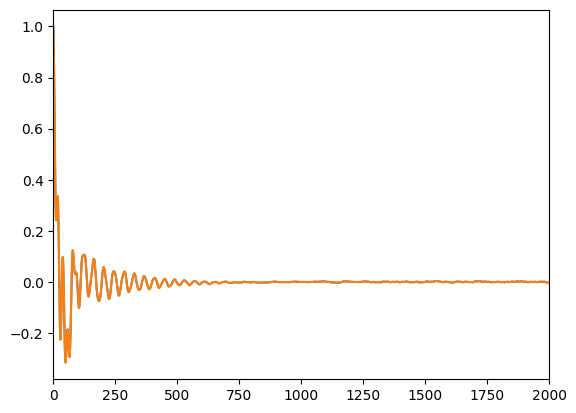

In [25]:
plt.plot(tau_list, results_vacf)
plt.plot(full_vacf[len(full_vacf) // 2 :])

plt.xlim(0.0, tau_list[-1])
plt.show()

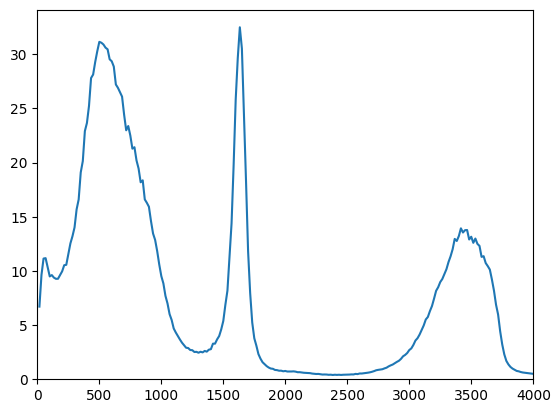

In [28]:
test_full_vacf = np.concatenate([results_vacf[::-1][:-1], results_vacf])
out = calc_power_spectrum(test_full_vacf, 0.5e-3)

mask = out[0] > 0.0


plt.plot(out[0][mask] * 100 / 3.0, out[1][mask])

plt.xlim(0.0, 4000)
plt.ylim(bottom=0.0)
plt.show()